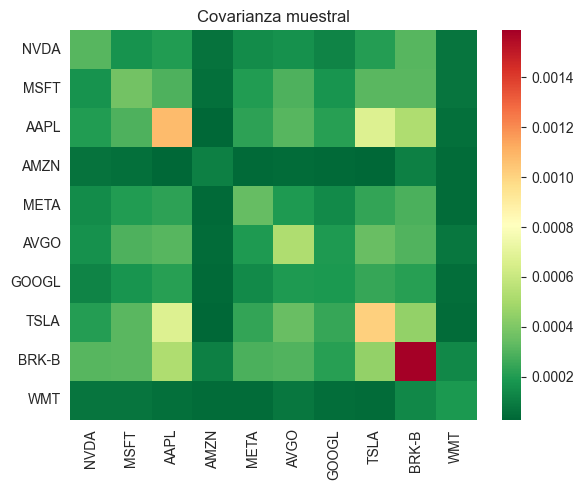


[QAOA] Mejor expectativa estimada: -0.000845
[QAOA] θ* = [2.44803982 6.0595127  0.52151587 5.42359625]

[Resultado QAOA-XY]
Bitstring (little-endian): 1010011000  (freq 1/8000)
Seleccionados (4 = B): ['AMZN', 'META', 'TSLA', 'WMT']
f(x*) = -0.001108

[Métricas aprox.]
Rentabilidad esperada anual ≈ 47.73%
Volatilidad anual ≈ 19.91%


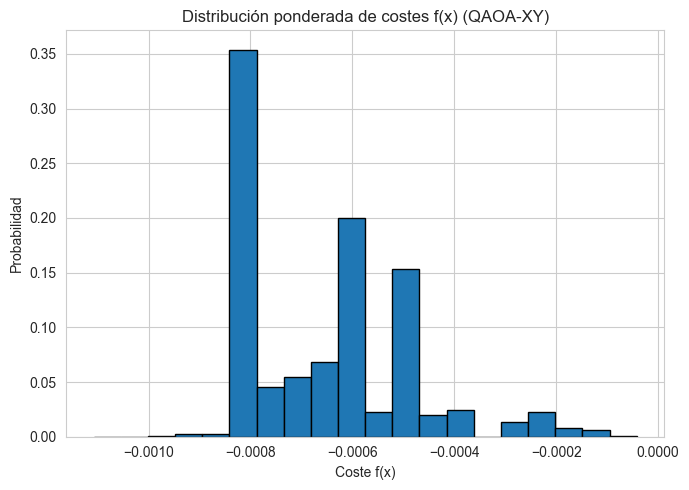

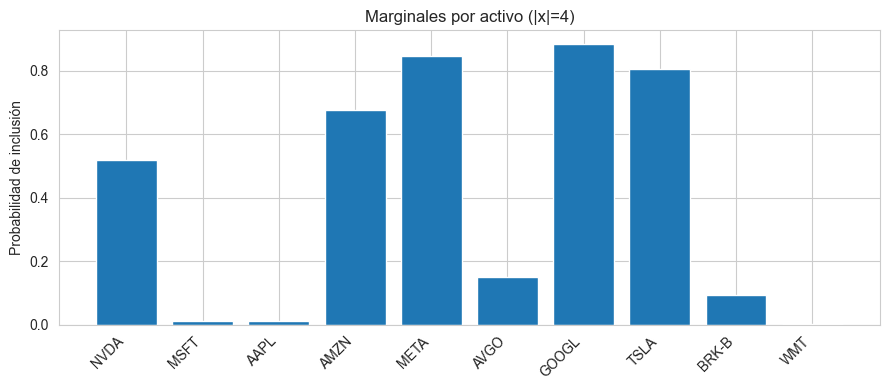

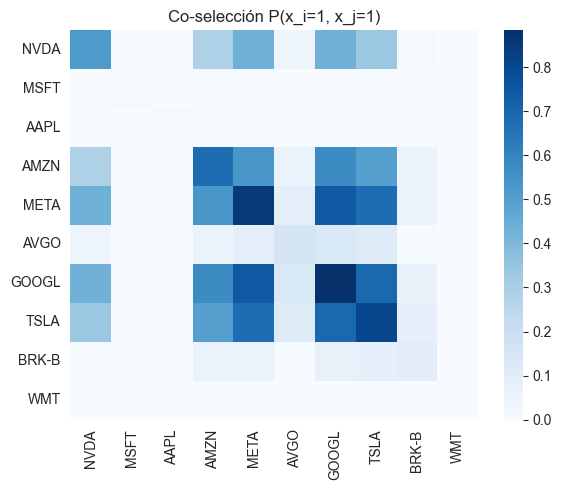

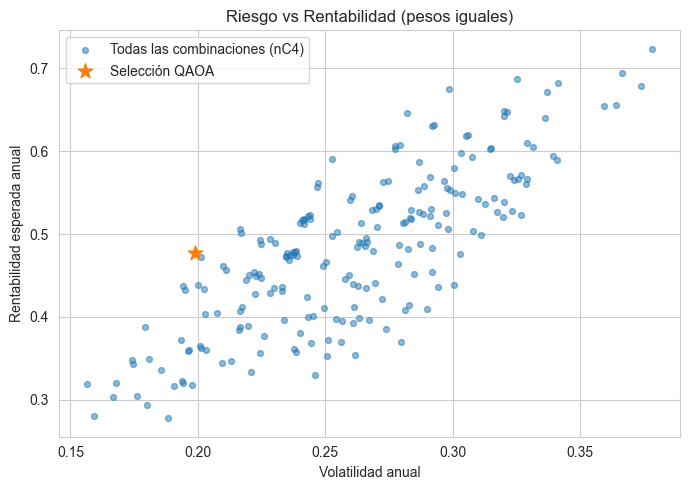

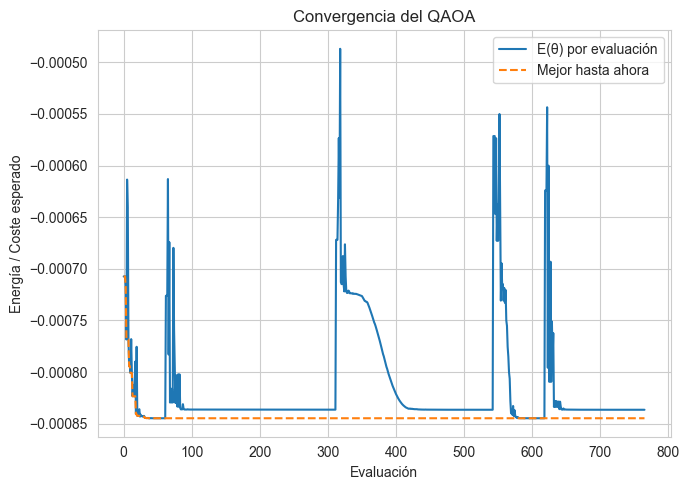


[Complejidad]
Qubits: 10, p: 2, params: 4
Pre-transpile -> depth: 62, size: 154, ops: {'rzz': 90, 'rz': 20, 'rxx': 20, 'ryy': 20, 'x': 4}
Post-transpile -> depth: 62, size: 150, ops: {'rzz': 90, 'rxx': 20, 'ryy': 20, 'rz': 16, 'u3': 4}
Tiempos -> Optimización: 9.42s | Muestreo: 0.04s


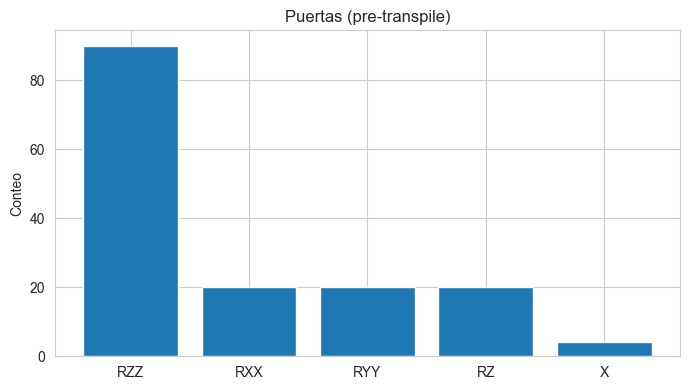


[Distribución |x|=B] Entropía: 2.3701 nats | ESS: 6.6


In [1]:
# =========================================================
# DATOS (Parte 1 compacta) + QAOA XY (Parte 2) + Visualizaciones
# =========================================================
import time, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime, timedelta
from sklearn.covariance import LedoitWolf
import yfinance as yf

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# ---------- Configuración de datos ----------
START_DATE = datetime.now() - timedelta(days=365*2)
END_DATE   = datetime.now()
TICKERS = ['NVDA','MSFT','AAPL','AMZN','META','AVGO','GOOGL','TSLA','BRK-B','WMT']

def fetch_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)
    prices = data['Adj Close'] if len(tickers)>1 else data['Adj Close'].to_frame(tickers[0])
    prices = prices.dropna()
    returns = prices.pct_change().dropna()
    mean_returns = returns.mean().values
    cov = returns.cov().values
    return mean_returns, cov, returns, prices

mean_returns, covariance_matrix, daily_returns, price_data = fetch_stock_data(TICKERS, START_DATE, END_DATE)

# Ledoit–Wolf (mejor estabilidad)
lw = LedoitWolf().fit(daily_returns)
shrunk_cov_matrix = lw.covariance_

# (opcional) heatmap rápido de covarianza muestral
plt.figure(figsize=(6,5))
sns.heatmap(covariance_matrix, annot=False, cmap='RdYlGn_r',
            xticklabels=TICKERS, yticklabels=TICKERS)
plt.title('Covarianza muestral'); plt.tight_layout(); plt.show()

# =========================================================
# QAOA con mixer XY (cardinalidad fija B) + Visualizaciones
# =========================================================
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from itertools import combinations

# ---------- Parámetros problema ----------
B = 4                  # cardinalidad (nº de activos seleccionados)
LAMBDA = 5.0           # aversión al riesgo
P_LAYERS = 2           # profundidad QAOA
SHOTS = 8000           # tiros de muestreo
SEED = 7               # reproducibilidad
USE_EQUAL_WEIGHT = True
rng = np.random.default_rng(SEED)

mu = mean_returns.copy()
Sigma = shrunk_cov_matrix.copy()
n = len(TICKERS)
assert 1 <= B <= n

# ---------- QUBO clásico ----------
# f(x)=x^T Q x + q^T x, con |x|=B y w = x/B
Q = (LAMBDA/(B**2))*Sigma if USE_EQUAL_WEIGHT else LAMBDA*Sigma
q = -(1.0/B)*mu if USE_EQUAL_WEIGHT else -mu
Q = 0.5*(Q+Q.T)

# ---------- QUBO -> Ising (Z) ----------
def qubo_to_ising(Q, q):
    J = np.zeros((n,n)); h = np.zeros(n); const = 0.0
    for i in range(n):
        for j in range(i+1,n):
            Jij = Q[i,j]/4.0; J[i,j]=Jij
            h[i] += -Q[i,j]/4.0; h[j] += -Q[i,j]/4.0
            const += Q[i,j]/4.0
    for i in range(n):
        h[i] += -(Q[i,i]/2.0) - (q[i]/2.0)
        const +=  (Q[i,i]/2.0) + (q[i]/2.0)
    return J,h,const

J,h,const_shift = qubo_to_ising(Q,q)

# ---------- Estado inicial ALEATORIO con |x|=B ----------
init_idx = rng.choice(n, size=B, replace=False)
init_bits = np.zeros(n, dtype=int); init_bits[init_idx]=1

# ---------- Ansatz QAOA + mixer XY (ring) ----------
def build_qaoa_xy(n,P,J,h,init_bits):
    qc = QuantumCircuit(n, name="QAOA_XY")
    for i,b in enumerate(init_bits):
        if b==1: qc.x(i)
    gammas=[Parameter(f"γ_{k}") for k in range(P)]
    betas =[Parameter(f"β_{k}") for k in range(P)]
    ring_pairs=[(i,(i+1)%n) for i in range(n)]
    for k in range(P):
        γ,β=gammas[k],betas[k]
        # Coste
        for i in range(n):
            if abs(h[i])>1e-15: qc.rz(2.0*γ*h[i], i)
        for i in range(n):
            for j in range(i+1,n):
                if abs(J[i,j])>1e-15: qc.append(RZZGate(2.0*γ*J[i,j]), [i,j])
        # Mixer XY
        for (i,j) in ring_pairs:
            qc.append(RXXGate(2.0*β), [i,j])
            qc.append(RYYGate(2.0*β), [i,j])
    return qc, gammas+betas

ansatz, theta_params = build_qaoa_xy(n,P_LAYERS,J,h,init_bits)

# ---------- Utilidades ----------
def f_qubo(x): return float(x @ Q @ x + q @ x)
def bitstr_from_int(k,n): return np.array(list(np.binary_repr(k,width=n)), dtype=int)
def bitarray_from_qiskit_string(s): return np.array(list(s[::-1]), dtype=int)  # little->logical

def bind_params(circ, mapping):
    try: return circ.assign_parameters(mapping, inplace=False)
    except Exception:
        try: return circ.bind_parameters(mapping)
        except Exception as e: raise RuntimeError(f"No se pudieron asignar parámetros: {e}")

def expectation_statevector(theta):
    circ_b = bind_params(ansatz, {p: float(t) for p,t in zip(theta_params, theta)})
    sv = Statevector.from_instruction(circ_b); amps = sv.data
    exp = 0.0
    for idx,amp in enumerate(amps):
        p = (amp.conjugate()*amp).real
        if p<1e-16: continue
        x = bitstr_from_int(idx,n)
        if x.sum()!=B: continue  # robustez
        exp += p * f_qubo(x)
    return exp

# ---------- Optimización con traza de energía ----------
qaoa_trace=[]
def objective_with_trace(th):
    val = expectation_statevector(th); qaoa_trace.append(val); return val

try:
    from scipy.optimize import minimize
    use_scipy=True
except Exception as e:
    print(f"[Aviso] SciPy no disponible ({e}). Búsqueda aleatoria.")
    use_scipy=False

def random_theta():
    return np.concatenate([rng.uniform(0,2*np.pi,size=P_LAYERS), rng.uniform(0,2*np.pi,size=P_LAYERS)])

t0_opt=time.perf_counter()
if use_scipy:
    best_val, best_theta = np.inf, None
    for _ in range(5):
        x0 = random_theta()
        res = minimize(objective_with_trace, x0, method="COBYLA", options={"maxiter":250,"rhobeg":0.5})
        if res.fun<best_val: best_val, best_theta = res.fun, res.x
else:
    best_val, best_theta = np.inf, None
    for _ in range(100):
        th = random_theta(); val = objective_with_trace(th)
        if val<best_val: best_val, best_theta = val, th
t1_opt=time.perf_counter()

print(f"\n[QAOA] Mejor expectativa estimada: {best_val:.6f}")
print(f"[QAOA] θ* = {best_theta}")

# ---------- Muestreo ----------
backend = AerSimulator()
meas_qc = bind_params(ansatz, {p: float(t) for p,t in zip(theta_params,best_theta)}).copy()
meas_qc.measure_all()
tqc = transpile(meas_qc, backend, optimization_level=1, seed_transpiler=SEED)

t0_samp=time.perf_counter()
res = backend.run(tqc, shots=SHOTS, seed_simulator=SEED).result()
t1_samp=time.perf_counter()
counts = res.get_counts()

# Filtrar cardinalidad y elegir mejor coste
cands=[]
for s,c in counts.items():
    x=bitarray_from_qiskit_string(s)
    if x.sum()==B: cands.append((s,c,f_qubo(x)))
if not cands: raise RuntimeError("No se observaron bitstrings |x|=B (muy raro con mixer XY).")
s_best,c_best,fx_best = min(cands, key=lambda t:t[2])
x_best = bitarray_from_qiskit_string(s_best)
sel_idx = np.where(x_best==1)[0]; sel_tickers=[TICKERS[i] for i in sel_idx]
print("\n[Resultado QAOA-XY]")
print(f"Bitstring (little-endian): {s_best}  (freq {c_best}/{SHOTS})")
print(f"Seleccionados ({len(sel_idx)} = B): {sel_tickers}")
print(f"f(x*) = {fx_best:.6f}")

# Métricas (pesos iguales)
w=np.zeros(n); w[sel_idx]=1.0/B
mu_day=float(mu@w); var_day=float(w@Sigma@w)
mu_ann=252*mu_day; std_ann=np.sqrt(252*var_day)
print("\n[Métricas aprox.]")
print(f"Rentabilidad esperada anual ≈ {mu_ann:.2%}")
print(f"Volatilidad anual ≈ {std_ann:.2%}")

# =========================================================
# VISUALIZACIONES
# =========================================================
# -- Muestras (solo |x|=B) --
rows=[]; total_shots=sum(counts.values())
for s,c in counts.items():
    x=bitarray_from_qiskit_string(s)
    if x.sum()!=B: continue
    rows.append({
        "bitstring": s, "shots": c, "prob": c/total_shots,
        "cost": f_qubo(x), "indices": np.where(x==1)[0],
        "tickers": ", ".join([TICKERS[i] for i in np.where(x==1)[0]])
    })
samples_df=pd.DataFrame(rows).sort_values(["prob","cost"], ascending=[False,True]).reset_index(drop=True)

# 1) Histograma de costes (ponderado)
plt.figure(figsize=(7,5))
plt.hist(samples_df["cost"], bins=20, weights=samples_df["prob"], edgecolor="black")
plt.xlabel("Coste f(x)"); plt.ylabel("Probabilidad")
plt.title("Distribución ponderada de costes f(x) (QAOA-XY)")
plt.tight_layout(); plt.show()

# 2) Marginales de inclusión por activo
p_incl=np.zeros(n)
for _,r in samples_df.iterrows():
    idx=np.array(r["indices"],dtype=int); x=np.zeros(n); x[idx]=1
    p_incl += r["prob"]*x
plt.figure(figsize=(9,4))
plt.bar(TICKERS, p_incl); plt.ylabel("Probabilidad de inclusión")
plt.title(f"Marginales por activo (|x|={B})"); plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# 3) Co-selección P(x_i=1,x_j=1)
P_ij=np.zeros((n,n))
for _,r in samples_df.iterrows():
    idx=np.array(r["indices"],dtype=int)
    for i in idx:
        for j in idx:
            P_ij[i,j]+=r["prob"]
plt.figure(figsize=(6,5))
sns.heatmap(P_ij, xticklabels=TICKERS, yticklabels=TICKERS, cmap="Blues")
plt.title("Co-selección P(x_i=1, x_j=1)"); plt.tight_layout(); plt.show()

# 4) Riesgo-Rentabilidad (todas las combinaciones vs QAOA)
def metrics_for_indices(sel_idx):
    idx=np.array(sel_idx,dtype=int).reshape(-1)
    w=np.zeros(n); w[idx]=1.0/B
    mu_day=float(mu@w); var_day=float(w@Sigma@w)
    return 252*mu_day, np.sqrt(252*var_day)
all_mu,all_std=[],[]
for comb in combinations(range(n),B):
    m,s=metrics_for_indices(comb); all_mu.append(m); all_std.append(s)
qaoa_mu,qaoa_std = metrics_for_indices(sel_idx)
plt.figure(figsize=(7,5))
plt.scatter(all_std, all_mu, s=18, alpha=0.5, label=f"Todas las combinaciones (nC{B})")
plt.scatter([qaoa_std],[qaoa_mu], s=120, marker="*", label="Selección QAOA", zorder=3)
plt.xlabel("Volatilidad anual"); plt.ylabel("Rentabilidad esperada anual")
plt.title("Riesgo vs Rentabilidad (pesos iguales)")
plt.legend(); plt.tight_layout(); plt.show()

# 5) Convergencia (energía vs evaluaciones)
if len(qaoa_trace)>0:
    y=np.array(qaoa_trace,dtype=float); best=np.minimum.accumulate(y)
    plt.figure(figsize=(7,5))
    plt.plot(y, label="E(θ) por evaluación"); plt.plot(best, linestyle="--", label="Mejor hasta ahora")
    plt.xlabel("Evaluación"); plt.ylabel("Energía / Coste esperado")
    plt.title("Convergencia del QAOA"); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No hay traza de energía.")

# 6) Complejidad del circuito (pre/post-transpile) + tiempos
bound_circ = bind_params(ansatz, {p: float(t) for p,t in zip(theta_params,best_theta)})
pre_depth, pre_size, pre_ops = bound_circ.depth(), bound_circ.size(), bound_circ.count_ops()
tqc_complex = transpile(bound_circ, backend, optimization_level=1, seed_transpiler=SEED)
post_depth, post_size, post_ops = tqc_complex.depth(), tqc_complex.size(), tqc_complex.count_ops()

print("\n[Complejidad]")
print(f"Qubits: {n}, p: {P_LAYERS}, params: {2*P_LAYERS}")
print(f"Pre-transpile -> depth: {pre_depth}, size: {pre_size}, ops: {dict(pre_ops)}")
print(f"Post-transpile -> depth: {post_depth}, size: {post_size}, ops: {dict(post_ops)}")
print(f"Tiempos -> Optimización: {(t1_opt-t0_opt):.2f}s | Muestreo: {(t1_samp-t0_samp):.2f}s")

labels,vals=[],[]
for k in ["rzz","rxx","ryy","rz","x"]:
    if k in pre_ops: labels.append(k.upper()); vals.append(int(pre_ops[k]))
if labels:
    plt.figure(figsize=(7,4))
    plt.bar(labels, vals); plt.title("Puertas (pre-transpile)"); plt.ylabel("Conteo")
    plt.tight_layout(); plt.show()

# 7) Entropía y tamaño efectivo de muestra de la distribución |x|=B
probs=samples_df["prob"].values; eps=1e-16
entropy=-np.sum(np.where(probs>0, probs*np.log(probs+eps), 0.0))
ess=1.0/np.sum((probs+eps)**2)
print(f"\n[Distribución |x|=B] Entropía: {entropy:.4f} nats | ESS: {ess:.1f}")

